In [ ]:
# This is an implementation for the GoogLeNet v1 based on
# https://github.com/tflearn/tflearn/blob/master/examples/images/googlenet.py
# for the plantvillage input-space

In [1]:
from __future__ import division, absolute_import

import tensorflow as tf
import tflearn

from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d, avg_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.merge_ops import merge
from tflearn.layers.estimator import regression

from tflearn.data_preprocessing import ImagePreprocessing

import h5py

import numpy as np

import os
from datetime import datetime

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

In [2]:
#reset graph
tf.reset_default_graph()

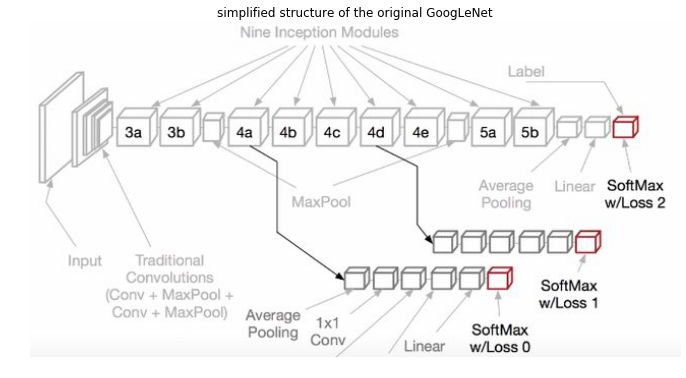

In [35]:
url = 'https://i.stack.imgur.com/U6O7Wl.png'
response = requests.get(url)
img = Image.open(BytesIO(response.content))

plt.figure(figsize=(14, 6))
plt.imshow(img)
plt.axis('off')
plt.title('simplified structure of the original GoogLeNet')
plt.show()

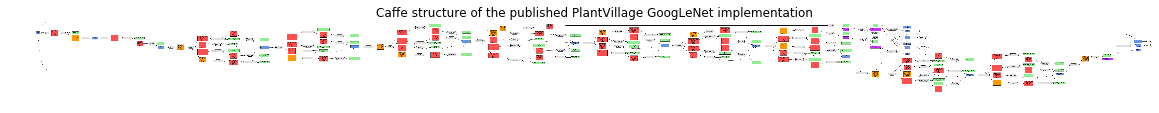

In [40]:
img = Image.open('train_val.png')
#plt.figure(figsize=(320, 80))
plt.figure(figsize=(14, 6))
plt.imshow(img)
plt.axis('off')
plt.title('Caffe structure of the published PlantVillage GoogLeNet implementation')
plt.show()
img.close()

In [3]:
#(0)
#(original input was 224x224x3)
#input layer (note: normalized at runtime for float. input is untouched uint8 additive rgb intensity)
#tf.placeholder = 
network = input_data(shape = [None, 256, 256, 3], dtype = tf.float32, \
                           name = 'data')
#256x256x3

In [ ]:
#input_data(shape = [None, 2], dtype = tf.bool, name = 'label')
#256x256x3

In [ ]:
#(1)
#1st convolution layer (note: is padded. output is halved due to strides)
conv1_7_7 = conv_2d(network, nb_filter = 64, filter_size = 7, padding = 'same', \
                    strides = 2, activation = 'relu', name = 'conv1_7x7_s2')
#128x128x64

In [ ]:
#(2)
#max pool layer
pool1_3_3 = max_pool_2d(conv1_7_7, kernel_size = 3, strides = 2, \
                           name = 'pool1_3x3_s2')
#(output is 64x64x64)

In [ ]:
#local response normalization layer
pool1_3_3 = local_response_normalization(pool1_3_3, alpha = 0.00002, beta = 0.75, \
                           name = 'pool1_norm1')

In [4]:
#(3)
#pseudo-inception layer (non-productive reduction layer)
conv2_3_3_red = conv_2d(pool1_3_3, nb_filter = 64, filter_size = 1, activation=  'relu', \
                           name = 'conv2_3x3_reduce')
conv2_3_3 = conv_2d(conv2_3_3_red, nb_filter = 192, filter_size = 3, activation = 'relu', \
                           name = 'conv2_3x3')
conv2_3_3 = local_response_normalization(conv2_3_3, name = 'conv2_norm2' )
#outputs 192 features
#64x64x192

In [ ]:
#(4)
#max pool layer (shrink receptive field with growing # of feature)
pool2_3_3 = max_pool_2d(conv2_3_3, kernel_size = 3, strides = 2, \
                          name = 'pool2_3x3_s2')
#32x32x192

In [ ]:
#(5)
#1st inception unit (3rd convolutional layer)
#alt 1 layer
inception_3a_1_1 = conv_2d(pool2_3_3, nb_filter = 64, filter_size = 1, activation = 'relu', \
                            name = 'inception_3a_1x1')
#32x32x64

#alt 2
#reduce number of features to 96 (1x1 convolution)
inception_3a_3_3_red = conv_2d(pool2_3_3, nb_filter = 96, filter_size = 1, activation = 'relu', \
                            name = 'inception_3a_3x3_reduce')
#32x32x96
#3x3 convolution
inception_3a_3_3 = conv_2d(inception_3a_3_3_red, nb_filter = 128, filter_size = 3, activation = 'relu', \
                            name = 'inception_3a_3x3')
#32x32x128

#alt 3
#reduce to 16 features (1x1 convolution)
inception_3a_5_5_red = conv_2d(pool2_3_3, nb_filter = 16, filter_size = 1, activation = 'relu', \
                            strides = 1, name = 'inception_3a_5x5_reduce' )
#32x32x16
#5x5 (expensive) convolution
inception_3a_5_5 = conv_2d(inception_3a_5_5_red, nb_filter = 32, filter_size = 5, activation = 'relu', \
                            strides = 1, padding = 'same', name = 'inception_3a_5x5')
#32x32x32

#alt 4 layer
inception_3a_pool = max_pool_2d(pool2_3_3, kernel_size = 3, strides = 1, \
                            name = 'inception_3a_pool')
#32x32x192
inception_3a_pool_1_1 = conv_2d(inception_3a_pool, nb_filter = 32, filter_size = 1, activation = 'relu', \
                            name = 'inception_3a_pool_proj')
#32x32x32

In [ ]:
#deep concatention (inception) layer for the 1st inception unit
inception_3a_output = merge([inception_3a_1_1, \
                             inception_3a_3_3, \
                             inception_3a_5_5, \
                             inception_3a_pool_1_1], \
                            mode = 'concat', axis = 3, \
                            name = 'inception_3a_output')
#64+128+32+32=32*2+32*2+32*4=32*8=256
#32x32x256

In [ ]:
#(6)
#2nd inception unit
inception_3b_1_1 = conv_2d(inception_3a_output, nb_filter = 128, filter_size = 1, activation = 'relu', \
                            name = 'inception_3b_1x1' )
#32x32x128

inception_3b_3_3_reduce = conv_2d(inception_3a_output, nb_filter = 128, filter_size = 1, activation = 'relu', \
                            name = 'inception_3b_3x3_reduce')
inception_3b_3_3 = conv_2d(inception_3b_3_3_reduce, nb_filter = 192, filter_size = 3,  activation = 'relu', \
                            name = 'inception_3b_3x3')
#32x32x192

inception_3b_5_5_reduce = conv_2d(inception_3a_output, nb_filter = 32, filter_size = 1, activation = 'relu', \
                            name = 'inception_3b_5x5_reduce')
inception_3b_5_5 = conv_2d(inception_3b_5_5_reduce, 96, filter_size = 5, strides = 1, \
                            padding = 'same', name = 'inception_3b_5x5')
#32x32x96

inception_3b_pool = max_pool_2d(inception_3a_output, kernel_size = 3, strides = 1, \
                            name = 'inception_3b_pool')
inception_3b_pool_1_1 = conv_2d(inception_3b_pool, 64, nb_filter = filter_size = 1, activation = 'relu', \
                            name = 'inception_3b_pool_proj')
#32x32x64

#concatenation layer
inception_3b_output = merge([inception_3b_1_1, \
                             inception_3b_3_3, \
                             inception_3b_5_5, \
                             inception_3b_pool_1_1], \
                            mode = 'concat', axis=3, \
                            name = 'inception_3b_output')
#32x32x480

In [ ]:
#(7)
#max pool layer
pool3_3_3 = max_pool_2d(inception_3b_output, kernel_size = 3, strides = 2, \
                            name = 'pool3_3x3_s2')
#16x16x480

In [5]:
#(8)
#3rd inception unit
inception_4a_1_1 = conv_2d(pool3_3_3, nb_filter = 192, filter_size = 1, activation = 'relu', \
                            name = 'inception_4a_1x1')
#16x16x192

inception_4a_3_3_reduce = conv_2d(pool3_3_3, nb_filter = 96, filter_size = 1, activation = 'relu', \
                           name = 'inception_4a_3x3_reduce')
inception_4a_3_3 = conv_2d(inception_4a_3_3_reduce, nb_filter = 208, filter_size=3, activation = 'relu', \
                            name = 'inception_4a_3x3')
#16x16x208

inception_4a_5_5_reduce = conv_2d(pool3_3_3, nb_filter = 16, filter_size = 1, activation='relu', \
                            name = 'inception_4a_5x5_reduce')
inception_4a_5_5 = conv_2d(inception_4a_5_5_reduce, nb_filter = 48, filter_size=5,  activation='relu', \
                            name = 'inception_4a_5x5')
#16x16x48

inception_4a_pool = max_pool_2d(pool3_3_3, kernel_size = 3, strides = 1, \
                            name='inception_4a_pool')
inception_4a_pool_1_1 = conv_2d(inception_4a_pool, nb_filter = 64, filter_size = 1, activation = 'relu', \
                            name='inception_4a_pool_proj')
#16x16x64

#deep concatenation layer
inception_4a_output = merge([inception_4a_1_1, \
                             inception_4a_3_3, \
                             inception_4a_5_5, \
                             inception_4a_pool_1_1], \
                            mode = 'concat', axis = 3, \
                            name = 'inception_4a_output')
#16x16x512

In [ ]:
#first softmax (training only)
loss_1_pool = avg_pool_2d(inception_4a_output, kernel_size = 5, strides = 3, \
                            name = 'loss1_ave_pool')
loss_1_conv = conv_2d(loss_1_pool, nb_filter = 128, filter_size = 1, activation = 'relu', \
                            name= 'loss1_conv')

#Fully connected layer; SoftMax activation #1
loss_1_fc = fully_connected(loss_1_conv, n_units = 1024, activation = 'relu', \
                            name = 'loss1_fc')
#drouput?

In [ ]:
#(9)
#4th inception unit
inception_4b_1_1 = conv_2d(inception_4a_output, 160, filter_size = 1, activation = 'relu', \
                            name='inception_4b_1x1')
#16x16x160

inception_4b_3_3_reduce = conv_2d(inception_4a_output, 112, filter_size = 1, activation = 'relu', \
                            name = 'inception_4b_3x3_reduce')
inception_4b_3_3 = conv_2d(inception_4b_3_3_reduce, 224, filter_size = 3, activation = 'relu', \
                            name = 'inception_4b_3x3')
#16x16x224

inception_4b_5_5_reduce = conv_2d(inception_4a_output, 24, filter_size = 1, activation = 'relu', \
                            name = 'inception_4b_5x5_reduce')
inception_4b_5_5 = conv_2d(inception_4b_5_5_reduce, 64, filter_size = 5,  activation = 'relu', \
                            name = 'inception_4b_5x5')
#16x16x64

inception_4b_pool = max_pool_2d(inception_4a_output, kernel_size = 3, strides = 1,  \
                            name = 'inception_4b_pool')
inception_4b_pool_1_1 = conv_2d(inception_4b_pool, 64, filter_size = 1, activation = 'relu', \
                            name = 'inception_4b_pool_1_1')
#16x16x64

inception_4b_output = merge([inception_4b_1_1, \
                             inception_4b_3_3, \
                             inception_4b_5_5, \
                             inception_4b_pool_1_1], \
                            mode = 'concat', axis = 3, \
                            name = 'inception_4b_output')
#16x16x512

In [ ]:
#(10)
#5th inception unit
inception_4c_1_1 = conv_2d(inception_4b_output, 128, filter_size = 1, activation = 'relu',\
                            name = 'inception_4c_1_1')

inception_4c_3_3_reduce = conv_2d(inception_4b_output, 128, filter_size = 1, activation = 'relu', \
                           name='inception_4c_3x3_reduce')
inception_4c_3_3 = conv_2d(inception_4c_3_3_reduce, 256,  filter_size = 3, activation = 'relu', \
                            name = 'inception_4c_3x3')

inception_4c_5_5_reduce = conv_2d(inception_4b_output, 24, filter_size = 1, activation = 'relu', \
                            name='inception_4c_5x5_reduce')
inception_4c_5_5 = conv_2d(inception_4c_5_5_reduce, 64,  filter_size = 5, activation = 'relu', \
                            name = 'inception_4c_5x5')

inception_4c_pool = max_pool_2d(inception_4b_output, kernel_size = 3, strides = 1, \
                            name = 'inception_4c_pool')
inception_4c_pool_1_1 = conv_2d(inception_4c_pool, 64, filter_size = 1, activation = 'relu', \
                            name = 'inception_4c_pool_proj')

inception_4c_output = merge([inception_4c_1_1, \
                             inception_4c_3_3, \
                             inception_4c_5_5, \
                             inception_4c_pool_1_1], \
                            mode = 'concat', axis = 3, \
                            name = 'inception_4c_output')
#16x16x512

In [ ]:
#(11)
#6th inception unit
inception_4d_1_1 = conv_2d(inception_4c_output, 112, filter_size = 1, activation = 'relu', \
                            name = 'inception_4d_1x1')
#112

inception_4d_3_3_reduce = conv_2d(inception_4c_output, 144, filter_size = 1, activation = 'relu', \
                            name = 'inception_4d_3x3_reduce')
inception_4d_3_3 = conv_2d(inception_4d_3_3_reduce, 288, filter_size = 3, activation = 'relu', \
                            name='inception_4d_3x3')
#288

inception_4d_5_5_reduce = conv_2d(inception_4c_output, 32, filter_size = 1, activation = 'relu', \
                            name = 'inception_4d_5x5_reduce')
inception_4d_5_5 = conv_2d(inception_4d_5_5_reduce, 64, filter_size = 5,  activation = 'relu', \
                            name = 'inception_4d_5x5')
#64

inception_4d_pool = max_pool_2d(inception_4c_output, kernel_size = 3, strides = 1, \
                            name = 'inception_4d_pool')
inception_4d_pool_1_1 = conv_2d(inception_4d_pool, 64, filter_size = 1, activation = 'relu', \
                            name = 'inception_4d_pool_proj')
#64

#merge
inception_4d_output = merge([inception_4d_1_1, \
                             inception_4d_3_3, \
                             inception_4d_5_5, \
                             inception_4d_pool_1_1], \
                            mode = 'concat', axis = 3, \
                            name = 'inception_4d_output')
#16x16x528

In [ ]:
#second softmax (training only)
loss_2_pool = avg_pool_2d(inception_4d_output, 5, strides = 3, \
                            name = 'loss2_ave_pool')
loss_2_conv = conv_2d(loss_2_pool, 128, filter_size = 1, activation = 'relu', \
                            name = 'loss2_conv')
loss_2_fc = fully_connected(loss_2_conv, 1024, activation = 'linear', \
                            name = 'loss2_fc')

In [ ]:
#(12)
#7th inception unit
inception_4e_1_1 = conv_2d(inception_4d_output, 256, filter_size = 1, activation = 'relu', \
                            name = 'inception_4e_1x1')
#256

inception_4e_3_3_reduce = conv_2d(inception_4d_output, 160, filter_size = 1, activation = 'relu', \
                           name = 'inception_4e_3x3_reduce')
inception_4e_3_3 = conv_2d(inception_4e_3_3_reduce, 320, filter_size = 3, activation = 'relu', \
                            name = 'inception_4e_3x3')
#320

inception_4e_5_5_reduce = conv_2d(inception_4d_output, 32, filter_size = 1, activation = 'relu', \
                            name = 'inception_4e_5x5_reduce')
inception_4e_5_5 = conv_2d(inception_4e_5_5_reduce, 128,  filter_size = 5, activation = 'relu', \
                            name='inception_4e_5x5')
#128

inception_4e_pool = max_pool_2d(inception_4d_output, kernel_size = 3, strides = 1, \
                           name = 'inception_4e_pool')
inception_4e_pool_1_1 = conv_2d(inception_4e_pool, 128, filter_size = 1, activation = 'relu', \
                            name = 'inception_4e_pool_proj')
#128

inception_4e_output = merge([inception_4e_1_1, \
                             inception_4e_3_3, \
                             inception_4e_5_5, \
                             inception_4e_pool_1_1], \
                            mode = 'concat', axis = 3, \
                            name = 'inception_4e_output')
#16x16x832

In [ ]:
#(13)
#maxpool layer
pool4_3_3 = max_pool_2d(inception_4e_output, kernel_size = 3, strides = 2, \
                            name = 'pool4_3x3_s2')
#8x8x832

In [ ]:
#(14)
#8th inception unit
inception_5a_1_1 = conv_2d(pool4_3_3, 256, filter_size = 1, activation = 'relu', \
                            name='inception_5a_1x1')
#8x8x256

inception_5a_3_3_reduce = conv_2d(pool4_3_3, 160, filter_size = 1, activation = 'relu', \
                           name = 'inception_5a_3x3_reduce')
inception_5a_3_3 = conv_2d(inception_5a_3_3_reduce, 320, filter_size = 3, activation = 'relu', \
                            name = 'inception_5a_3x3')
#8x8x320

inception_5a_5_5_reduce = conv_2d(pool4_3_3, 32, filter_size = 1, activation = 'relu', \
                           name = 'inception_5a_5x5_reduce')
inception_5a_5_5 = conv_2d(inception_5a_5_5_reduce, 128, filter_size = 5,  activation = 'relu', \
                            name = 'inception_5a_5x5')
#8x8x128 

inception_5a_pool = max_pool_2d(pool4_3_3, kernel_size = 3, strides = 1, \
                           name = 'inception_5a_pool')
inception_5a_pool_1_1 = conv_2d(inception_5a_pool, 128, filter_size = 1, activation = 'relu', \
                            name = 'inception_5a_pool_proj')
#128

inception_5a_output = merge([inception_5a_1_1, \
                             inception_5a_3_3, \
                             inception_5a_5_5, \
                             inception_5a_pool_1_1], \
                            mode = 'concat', axis = 3, \
                            name = 'inception_5a_output')
#8x8x832

In [ ]:
#(15)
#9th and final inception unit
inception_5b_1_1 = conv_2d(inception_5a_output, 384, filter_size=1,activation='relu', \
                            name='inception_5b_1_1')
#384

inception_5b_3_3_reduce = conv_2d(inception_5a_output, 192, filter_size=1, activation='relu', \
                                  name='inception_5b_3_3_reduce')
inception_5b_3_3 = conv_2d(inception_5b_3_3_reduce, 384,  filter_size=3,activation='relu', \
                            name='inception_5b_3_3')
#384

inception_5b_5_5_reduce = conv_2d(inception_5a_output, 48, filter_size=1, activation='relu', \
                                  name='inception_5b_5_5_reduce')
inception_5b_5_5 = conv_2d(inception_5b_5_5_reduce, 128, filter_size=5,  activation='relu', \
                            name='inception_5b_5_5' )
#128

inception_5b_pool = max_pool_2d(inception_5a_output, kernel_size = 3, strides = 1, \
                            name = 'inception_5b_pool')
inception_5b_pool_1_1 = conv_2d(inception_5b_pool, 128, filter_size = 1, activation = 'relu', \
                            name = 'inception_5b_pool_proj')
#128

inception_5b_output = merge([inception_5b_1_1, \
                             inception_5b_3_3, \
                             inception_5b_5_5, \
                             inception_5b_pool_1_1], \
                            mode = 'concat', axis = 3, \
                            name = 'inception_5b_output')
#8x8x1024 (768+256=1024)

In [ ]:
#(16)
#average pool layer

#option I: original
pool5_7_7 = avg_pool_2d(inception_5b_output, kernel_size = 7, strides = 1, padding = 'VALID', \
                            name = 'pool5_7x7_s1')
#2x2x1024

#option II: new (#original is 7x7 but since there's no intermediate fully connected... )
#pool5_7_7 = avg_pool_2d(inception_5b_output, kernel_size = 8, strides = 1, padding = 'VALID',\
#                            name = 'pool5_8x8_s1')
#1x1x1024

In [6]:
#(17)
pool5_7_7_drop = dropout(pool5_7_7, keep_prob = 0.4, name = 'pool5_drop_7x7')
#2x2x1024
#1x1x1024

In [ ]:
#(18) only "pure" fully connected layer
loss3_fc = fully_connected(pool5_7_7_drop, n_units = 1000, activation = 'linear', \
                            name = 'loss3_classifier')
#1x1x1000

In [ ]:
#end of googlnet graph set up (with the exclusion of last layer - "loss")

#start of googlenet computational model

In [ ]:
#metric = tflearn.metrics.Top_k(k=1)
metric = tflearn.metrics.Top_k(k=5)

In [ ]:
#optimizer
#loss: A Tensor containing the value to minimize.
#var_list: Optional list or tuple of tf.Variable to update to minimize loss. Defaults to the list of variables collected in the graph under the key GraphKey.TRAINABLE_VARIABLES.

In [7]:
#N_CLASSES = 38, 29
#N_CLASSES = 13
N_CLASSES = 38

#tf.train.AdamOptimizer

model_name_short = 'model_googlenet_v1_plantvillage_{0}'.format(metric.name)
model_name = '{0}_{1}_{2}_{3}'.format(model_name_short, activation_fn, optimizer, loss_objective)
model_directory = '{0}/{1}'.format(os.getcwd(), model_name)
model_pb = '{0}/{1}/{1}.pbtxt'.format(os.getcwd(), model_name)
model_path = '{0}/{1}/{1}.tflearn'.format(os.getcwd(), model_name)
checkpoint_path = '{0}/{1}/{1}'.format(os.getcwd(),model_name)
log_dir = '{0}/tflearn_logs/'.format(os.getcwd())

if not os.path.isdir(model_directory):
    os.mkdir(model_directory)
print(model_name)

model_googlenet_plantvillage_select_preprocessed_top5_softmax_adagrad_categorical_crossentropy


In [ ]:
#Fully connected layer; SoftMax activation #1 #Fully connected layer; SoftMax activation #2 
#classifier1 = fully_connected(loss1_fc, N_CLASSES, activation = 'softmax')
classifier1 = fully_connected(loss_1_fc, N_CLASSES, activation = 'softmax', \
                            name = 'loss1_classifier')
#transform_dropout: float: Keep probability on the highway transform gate.
#metrics (top-1, top-5)

In [ ]:
#Fully connected layer; SoftMax activation #2 (should not be implemented)
#classifier2 = fully_connected(loss2_fc, N_CLASSES, activation = 'softmax')
classifier2 = fully_connected(loss_2_fc, N_CLASSES, activation = 'softmax', \
                            name = 'loss1_classifier')
#metrics (top-1, top-5)

In [8]:
#Fully connected layer; SoftMax activation #3
classifier3 = fully_connected(loss3_fc, N_CLASSES, activation = 'softmax', \
                           name = 'prob')

In [9]:
# The optimizer layer loss function and optimizater)
network = regression(classifier3, optimizer = 'momentum', \
                     loss = 'categorical_crossentropy', \
                     learning_rate =  0.001, \
                     metric = metric, \
                     n_classes = N_CLASSES)

In [11]:
# model trainer setup
model = tflearn.DNN(network, checkpoint_path = checkpoint_path, \
                    max_checkpoints = 5, \
                    tensorboard_verbose = 3, \
                    tensorboard_dir = log_dir)
print(model_name)

model_googlenet_plantvillage_select_preprocessed_top5_softmax_adagrad_categorical_crossentropy


In [17]:
file_h5f = '/home/martin/Pictures/h5s_plantvillage/plantvillage_svm.h5'

# read plantvillage image dataset
h5f = h5py.File(file_h5f, 'r')
#images
X = h5f['X']
#labels
Y = h5f['Y']

#train model
model.fit(X, Y, n_epoch = 50, validation_set = 0.2, shuffle = True, \
                show_metric = True, batch_size = 64, snapshot_step = 50, \
                snapshot_epoch = False, run_id = model_name)
h5f.close()

Training Step: 16733  | total loss: 0.74642 | time: 608.857s
| AdaGrad | epoch: 103 | loss: 0.74642 - top5: 0.9676 -- iter: 7000/7000


In [ ]:
#end of training stage

In [18]:
#save weight to file (protobuf)
model.save(model_path)

In [19]:
#save (a textual model of) graph to file
sess = tf.Session()

model_pb = '{0}/{0}.pbtxt'.format(model_name)
with sess.as_default():
  assert tf.get_default_session() is sess
tf.train.write_graph(sess.graph_def, log_dir, model_pb)

'/home/martin/Python/tflearn_logs/model_googlenet_plantvillage_select_preprocessed_top5_softmax_adagrad_categorical_crossentropy/model_googlenet_plantvillage_select_preprocessed_top5_softmax_adagrad_categorical_crossentropy.pbtxt'

In [ ]:
#reload saved model weights (requires prebuilt graph)
model.load(model_path)

In [ ]:
#below is playtesting of results

In [ ]:
# naive model evaluation
h5f = h5py.File(file_h5f, 'r')
X = h5f['X']
Y = h5f['Y']

(count_t, count_f) = (0, 0)
for i in range(10000):
    pred = model.predict(X[i:i+1,:,:,:]).argmax()
    true = Y[i:i+1].argmax()
    if (pred == true):
        count_t +=1
    else:
        count_f +=1
print('good: {0}'.format(count_t))
print('bad: {0}'.format(count_f))
h5f.close()

In [82]:
LIMIT = 1000 #save time by evaulating only a part

h5f = h5py.File(file_h5f, 'r')
X = h5f['X']
Y = h5f['Y']
k = 35

top_op = tflearn.metrics.top_k_op(model.predict(X[0:LIMIT,:,:,:]), Y[0:LIMIT,:], k)
# Calculate Top-K accuracy 
top_accuracy = sess.run(top_op)
print('top-{0} accuracy is {1}%'.format(k, top_accuracy*100))

h5f.close()

(8751, 256, 256, 3)
Tensor("Top_5_4/Mean:0", shape=(), dtype=float32)
0.3


In [ ]:
LIMIT = 192

predict_blight = model.predict_label(X[0:LIMIT,:])
label_blight = Y[0:LIMIT, :]
print(np.where(label_blight[:,1]))
print(np.where(predict_blight[:,0]))

score = model.evaluate(X[0:LIMIT,:], Y[0:LIMIT,:])
print('Test accuarcy: %0.4f%%' % (score[0] * 100))

print ("Precision: {}%".format(100*metrics.precision_score(label_blight, predict_blight, average="weighted")))
print ("Recall: {}%".format(100*metrics.recall_score(label_blight, predict_blight, average="weighted")))
print ("f1_score: {}%".format(100*metrics.f1_score(label_blight, predict_blight, average="weighted")))

#print ("(2) Recall: {}%".format(tf.metrics.recall(label_blight, predict_blight))

h5.close()